## Question 1 — Implementation of an Alpha-Stable Distribution Generator

### Objective 
The first step involves implementing a generator that simulates random variables following an alpha-stable distribution 
𝑆
(
𝛼
,
𝛽
,
𝜎
,
𝜇
), as described in Appendix B of Sisson (2011).
The algorithm used follows the approach of Chambers, Mallows, and Stuck (1976), which relies on the transformation of two elementary distributions.


In [2]:
import numpy as np

def sample_alpha_stable(alpha, beta, gamma=1, delta=0, size=1):
    U = np.pi * (np.random.rand(size) - 0.5)  # Uniforme sur (-π/2, π/2)
    W = np.random.exponential(scale=1.0, size=size)  # Exp(1)

    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = np.cos((1 - alpha) * U) / W
        X = numerator / denominator * (inner) ** ((1 - alpha) / alpha)
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2 * W * np.cos(U)) / ((np.pi / 2) + beta * U))
        X = B

    return gamma * X + delta



### Why is this generator is valid ? 
#### a- Empirical Validation: Visualization of Some Distributions
We test the generator for different values of 
𝛼
and 
𝛽, by presenting the histograms of the simulated samples.



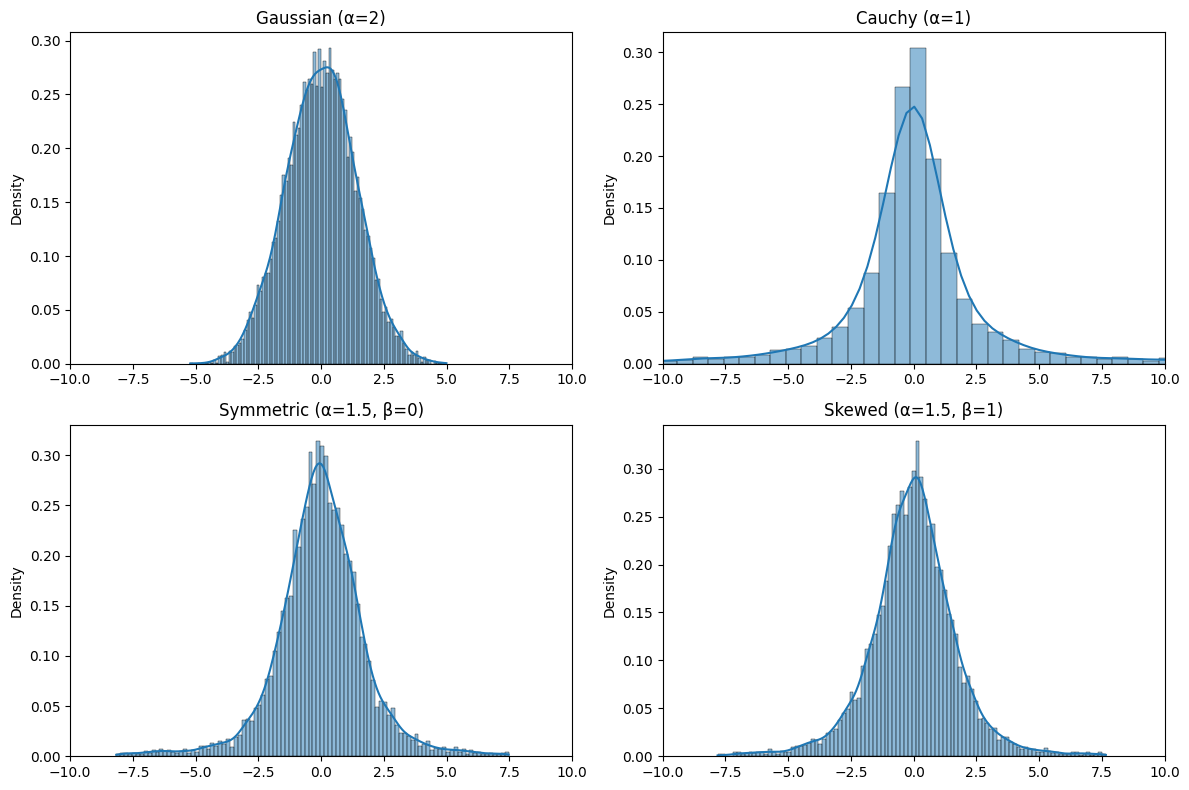

In [12]:


# Paramètres à tester
params = [
    (2.0, 0, 1, 0, 'Gaussian (α=2)'),
    (1.0, 0, 1, 0, 'Cauchy (α=1)'),
    (1.5, 0, 1, 0, 'Symmetric (α=1.5, β=0)'),
    (1.5, 1, 1, 0, 'Skewed (α=1.5, β=1)'),
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (alpha, beta, gamma, delta, title) in enumerate(params):
    data = sample_alpha_stable(alpha, beta, gamma, delta, size=10000)
    
    # On élimine les valeurs extrêmes (1% aux deux extrémités) pour les cas Cauchy et Skewed
    if alpha <= 1.5:
        lower, upper = np.percentile(data, 1), np.percentile(data, 99)
        data = data[(data >= lower) & (data <= upper)]
    
    sns.histplot(data, kde=True, stat='density', ax=axs[i], bins=100)
    axs[i].set_title(title)
    axs[i].set_xlim(-10, 10)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Density")

plt.tight_layout()
plt.show()


#### b- Validation via the Characteristic Function
Another way to test the validity of the generator is to compare the empirical characteristic function.

Since the density of alpha-stable distributions is generally not available in closed form (except in particular cases), it cannot be directly compared to an empirical estimate. However, their characteristic function (CF) is explicitly known and serves as an effective tool for numerically validating an alpha-stable random variable generator.

##### Definition
The characteristic function of a random variable 
𝑋 is defined by: 
$$
\varphi_X(t) = \mathbb{E}[e^{itX}]
$$

For X∼S(α,β,γ,δ), the theoretical characteristic function is:

- if  $ \alpha \neq 1 $ :

$$
\varphi_X(t) = \exp\left( -\gamma^\alpha |t|^\alpha \left[ 1 - i\beta\, \text{sign}(t) \tan\left( \frac{\pi \alpha}{2} \right) \right] + i \delta t \right)
$$

- if  $ \alpha = 1 $ :

$$
\varphi_X(t) = \exp\left( -\gamma |t| \left[ 1 + i\beta \frac{2}{\pi} \, \text{sign}(t) \log|t| \right] + i \delta t \right)
$$

##### Method
We generate a large number of observations $ X_1, \dots, X_N $ using the generator, and then compute the empirical estimator:
We then compare the results obtained through the curves:

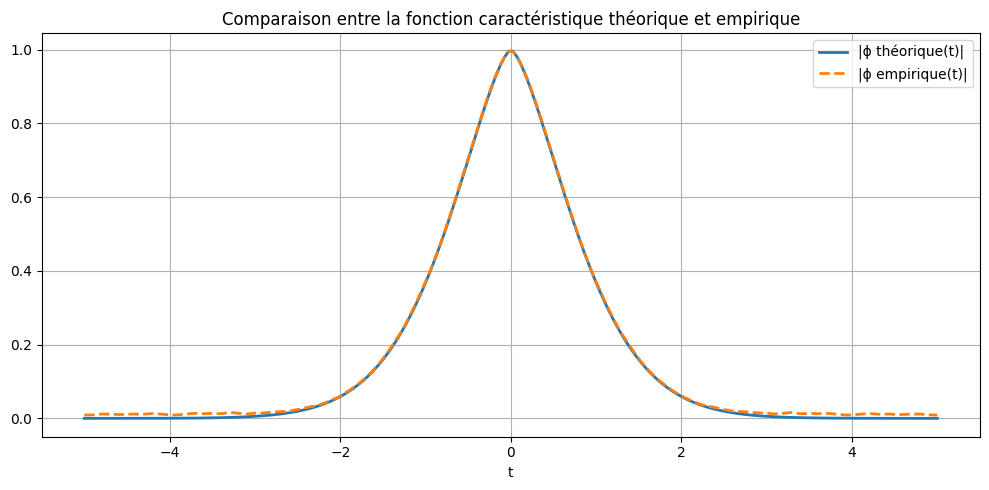

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction caractéristique théorique
def theoretical_cf(t, alpha, beta, gamma=1, delta=0):
    if alpha != 1:
        return np.exp(
            -gamma**alpha * np.abs(t)**alpha *
            (1 - 1j * beta * np.sign(t) * np.tan(np.pi * alpha / 2)) +
            1j * delta * t
        )
    else:
        return np.exp(
            -gamma * np.abs(t) *
            (1 + 1j * beta * (2 / np.pi) * np.sign(t) * np.log(np.abs(t))) +
            1j * delta * t
        )

# Estimateur empirique de la fonction caractéristique
def empirical_cf(t_vals, samples):
    return np.array([np.mean(np.exp(1j * t * samples)) for t in t_vals])

# Paramètres de test
alpha = 1.5
beta = 0
gamma = 1
delta = 0
N = 10_000

# Génération d'échantillons
samples = sample_alpha_stable(alpha, beta, gamma, delta, size=N)

# Grille de t
t_vals = np.linspace(-5, 5, 200)

# Fonction caractéristique théorique et empirique
phi_theo = theoretical_cf(t_vals, alpha, beta, gamma, delta)
phi_emp = empirical_cf(t_vals, samples)

# Tracé des modules
plt.figure(figsize=(10, 5))
plt.plot(t_vals, np.abs(phi_theo), label="|ϕ théorique(t)|", lw=2)
plt.plot(t_vals, np.abs(phi_emp), label="|ϕ empirique(t)|", lw=2, linestyle="--")
plt.xlabel("t")
plt.title("Comparaison entre la fonction caractéristique théorique et empirique")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 2 — RQMC 

In this section, we will adapt our alpha-stable generator using **RQMC points** (Randomized Quasi-Monte Carlo). We will then compare the results obtained using RQMC with those from standard Monte Carlo.

RQMC generators, such as Sobol, are designed to distribute sampling points more uniformly in space, which allows for better coverage of the integration interval with fewer points, while maintaining the statistical properties of interest. This leads to a more accurate estimation of integrals, which is particularly useful in the simulation of alpha-stable distributions.

The idea here is to **generate the uniform points** needed to transform these points into variables following a **uniform distribution** over the interval $ (-\pi/2, \pi/2) $ , and then generate an **exponential distribution**.

- **Uniform distribution**: This is quite simple to implement by directly using the points generated by RQMC, which are uniformly distributed in the interval $[0, 1]$ . By transforming them appropriately, we obtain uniformly distributed points in the interval $ (-\pi/2, \pi/2) $.

- **Exponential distribution**: To generate the exponential distribution, we used the **inversion theorem**. Given that if $ U \sim \text{Uniform}(0, 1) $ , the inverse transformation $ W = -\log(1 - U) $ allows us to obtain a variable following an exponential distribution with rate parameter $ \lambda = 1 $.


## Question 3
The objective of this question is to implement the methods described in the article. The ABC (Approximate Bayesian Computation) algorithm, also referred to as Likelihood-free Bayesian inference in the paper, allows simulation from an approximate posterior model while avoiding explicit evaluation of the likelihood function.

# Why should we use ABC rejection?

In the context of alpha-stable random variables, it is impossible to calculate p(y|θ) and therefore to obtain the target posterior distribution π(y|θ) ∝ p(y|θ) · π(θ). 

A) Implementation of ABC rejection

Data y⋆

Model p(y|θ) with the following properties:
(a) We can simulate from p(y|θ)
(b) We cannot compute the likelihood p(y|θ)
(Many scientific models fall into this category.)

A- ABC Reject Algorithm 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import qmc 
from scipy.stats import multivariate_normal


In [4]:
# ——————————————————————————————————————————————
# 1. Statistiques de résumé S₁ (McCulloch)
# ——————————————————————————————————————————————

def mcculloch_stats(data, gamma):
    """
    Calcule les 4 statistiques de McCulloch pour une série `data` :
      - v_alpha = (q95 − q05) / (q75 − q25)
      - v_beta  = (q95 + q05 − 2 q50) / (q95 − q05)
      - v_gamma = (q75 − q25) / gamma
      - v_delta = mean(data)
    
    Paramètres
    ----------
    data : array-like
        Jeu de données simulées ou observées.
    gamma : float
        Valeur de gamma utilisée pour normaliser v_gamma.
    
    Retour
    ------
    dict
        {
          "v_alpha": ...,
          "v_beta" : ...,
          "v_gamma": ...,
          "v_delta": ...
        }
    """
    # Calcul des quantiles nécessaires
    q05, q25, q50, q75, q95 = np.quantile(data, [0.05, 0.25, 0.50, 0.75, 0.95])
    
    # Formules de McCulloch
    v_alpha = (q95 - q05) / (q75 - q25)
    v_beta  = (q95 + q05 - 2 * q50) / (q95 - q05)
    v_gamma = (q75 - q25) / gamma
    v_delta = np.mean(data)
    
    return {
        "v_alpha": v_alpha,
        "v_beta" : v_beta,
        "v_gamma": v_gamma,
        "v_delta": v_delta
    }

In [38]:
def abc_reject(y_star, alpha_range, beta_range, gamma_range, delta_range, n_samples, epsilon):
    """
    Algorithme ABC-rejection pour estimer les paramètres (alpha, beta, gamma, delta)
    d'une loi alpha-stable, en comparant les statistiques de McCulloch.

    Retourne également les MMSE des paramètres et leurs écarts-types, et affiche leurs distributions.
    """
    accepted_samples = []
    rejections = 0
    acceptances = 0
    gamma_obs = 10.0
    acceptance_history = []  # Pour stocker l'historique des acceptations

    # Statistiques McCulloch observées
    y_star_mcculloch = mcculloch_stats(y_star, gamma=gamma_obs)
    print("Statistiques McCulloch observées :", y_star_mcculloch)

    keys = ['v_alpha', 'v_beta', 'v_gamma', 'v_delta']

    # Boucle ABC-reject
    while len(accepted_samples) < n_samples:
        alpha = np.random.uniform(*alpha_range)
        beta  = np.random.uniform(*beta_range)
        gamma = np.random.uniform(*gamma_range)
        delta = np.random.uniform(*delta_range)

        y_sim = sample_alpha_stable(alpha, beta, gamma, delta, size=len(y_star))
        sim_stats = mcculloch_stats(y_sim, gamma=gamma)

        sim_vec = np.array([sim_stats[k] for k in keys])
        obs_vec = np.array([y_star_mcculloch[k] for k in keys])
        distance = np.linalg.norm(sim_vec - obs_vec)
        
        if distance < epsilon:
            accepted_samples.append({'alpha': alpha, 'beta': beta,
                                   'gamma': gamma, 'delta': delta,
                                   'distance': distance, 'sim_stats': sim_stats})
            acceptances += 1
        else:
            rejections += 1
        
        # Enregistrement du taux d'acceptation à chaque itération
        acceptance_history.append(acceptances / (acceptances + rejections))

    # Graphique de l'évolution du taux d'acceptation
    plt.figure(figsize=(10, 6))
    plt.plot(acceptance_history, color='blue')
    plt.title("Évolution du taux d'acceptation")
    plt.xlabel("Nombre d'itérations")
    plt.ylabel("Taux d'acceptation")
    plt.grid(True)
    plt.show()

    # Extraction des paramètres acceptés
    alphas = [s['alpha'] for s in accepted_samples]
    betas  = [s['beta']  for s in accepted_samples]
    gammas = [s['gamma'] for s in accepted_samples]
    deltas = [s['delta'] for s in accepted_samples]

    # Calcul des MMSE (mean of accepted) et leurs écarts-types
    mmse_alpha = np.mean(alphas)
    mmse_beta  = np.mean(betas)
    mmse_gamma = np.mean(gammas)
    mmse_delta = np.mean(deltas)
    
    std_alpha = np.std(alphas)
    std_beta  = np.std(betas)
    std_gamma = np.std(gammas)
    std_delta = np.std(deltas)
    
    print(f"MMSE estimates -> alpha: {mmse_alpha:.4f} ({std_alpha:.4f}), beta: {mmse_beta:.4f} ({std_beta:.4f}), gamma: {mmse_gamma:.4f} ({std_gamma:.4f}), delta: {mmse_delta:.4f} ({std_delta:.4f})")

    # Affichage des distributions
    fig, axes = plt.subplots(2, 2, figsize=(10,8))
    axes = axes.flatten()
    axes[0].hist(alphas, bins=20)
    axes[0].set_title('Distribution de alpha')
    axes[1].hist(betas, bins=20)
    axes[1].set_title('Distribution de beta')
    axes[2].hist(gammas, bins=20)
    axes[2].set_title('Distribution de gamma')
    axes[3].hist(deltas, bins=20)
    axes[3].set_title('Distribution de delta')
    for ax in axes:
        ax.set_xlabel('Valeur')
        ax.set_ylabel('Fréquence')
    plt.tight_layout()
    plt.show()

    return accepted_samples, {'mmse': {'alpha': mmse_alpha, 'beta': mmse_beta,
                                      'gamma': mmse_gamma, 'delta': mmse_delta},
                            'std': {'alpha': std_alpha, 'beta': std_beta,
                                   'gamma': std_gamma, 'delta': std_delta}}

Statistiques McCulloch observées : {'v_alpha': 2.698784588967932, 'v_beta': 0.007849622187142006, 'v_gamma': 2.016128879271656, 'v_delta': 10.093968653343511}


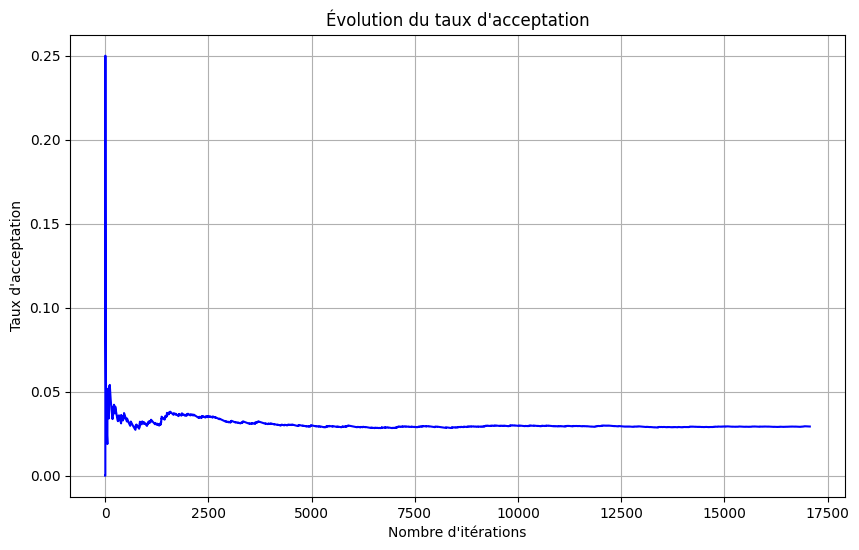

MMSE estimates -> alpha: 1.6874 (0.1860), beta: -0.0337 (0.5643), gamma: 7.6792 (4.1291), delta: 10.0817 (1.5190)


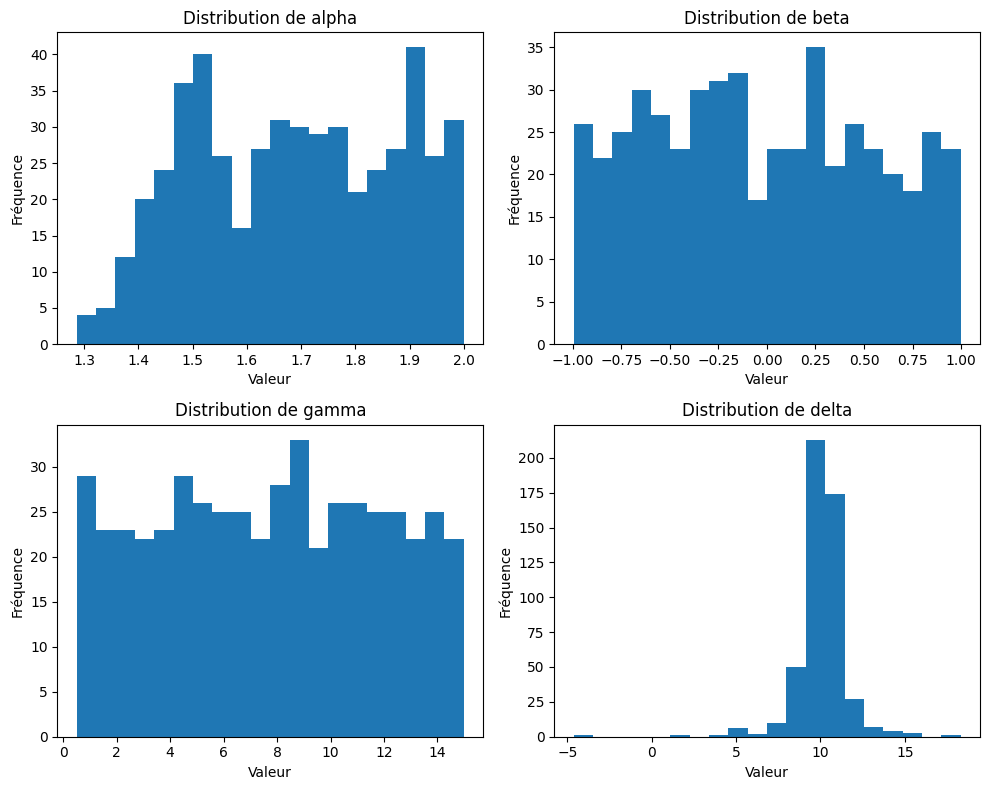

In [70]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate a set of observed data
y_star = sample_alpha_stable(1.7, 0.9, 10, 10, size=1000)

# Run ABC rejection sampling
accepted_samples, stats = abc_reject(
    y_star=y_star,
    alpha_range=(1.0, 2.0),
    beta_range=(-1.0, 1.0),
    gamma_range=(0.5, 15),
    delta_range=(-20, 20),
    n_samples=500,
    epsilon=1
)

# Store MMSE and standard deviation values
alpha_reject_mean = stats['mmse']['alpha']
beta_reject_mean = stats['mmse']['beta']
gamma_reject_mean = stats['mmse']['gamma']
delta_reject_mean = stats['mmse']['delta']

alpha_reject_std = stats['std']['alpha']
beta_reject_std = stats['std']['beta']
gamma_reject_std = stats['std']['gamma']
delta_reject_std = stats['std']['delta']


Les estimations MMSE révèlent une bonne estimation de Alpha et delta. Cependant, la méthode ABC-reject présente deux limitations majeures : 
1) Le taux de rejet élevé rend l'algorithme coûteux en termes de calcul
2) L'absence de pondération des échantillons acceptés ne permet pas de différencier leur qualité relative
Ces limitations seront adressées par les méthodes MCMC et SMC qui introduisent respectivement une chaîne de Markov et des poids pour les particules.


## B- ABC - MCMC

Dans les méthodes ABC-MCMC et ABC-SMC, le noyau gaussien et l'estimateur de covariance jouent un rôle crucial pour plusieurs raisons :


Le noyau gaussien K_ε(S(Y), S(Y^\star)) est défini par S(Y) ∼ N(S(Y^\star), ε²Σ)
Il permet de quantifier la similarité entre les statistiques des données simulées S(Y) et observées S(Y^\star) :  Plus la distance entre S(Y) et S(Y^\star) est petite, plus la probabilité d'acceptation est élevée
#
La Prise en compte de la structure de corrélation : Par exemple, si deux statistiques sont fortement corrélées, leur contribution conjointe à la distance sera ajustée


Convergence théorique : L'utilisation d'un noyau gaussien permet de garantir la convergence de l'algorithme La matrice de covariance correctement estimée assure que la distribution cible est bien approchée


In [21]:
# ——————————————————————————————————————————————
# Estimation de Σ̂ via P tirages à θ̂
# ——————————————————————————————————————————————

def estimate_covariance_s1(theta_hat, P=1000, size=1000):
    """
    Estime la covariance des statistiques S1 sous θ̂.
    
    Paramètres :
    - theta_hat : dictionnaire avec les paramètres (alpha, beta, gamma, delta)
    - P : nombre de simulations à effectuer (par défaut 1000)
    - size : taille de chaque échantillon simulé (par défaut 1000)
    
    Retour :
    - cov_matrix : matrice de covariance (3x3) des statistiques S1 = (v_alpha, v_beta, v_gamma)
    """
    samples = []
    for _ in range(P):
        y_sim = sample_alpha_stable(
            alpha=theta_hat["alpha"],
            beta=theta_hat["beta"],
            gamma=theta_hat["gamma"],
            delta=theta_hat["delta"],
            size=size
        )
        s = mcculloch_stats(y_sim, gamma=theta_hat["gamma"])
        samples.append([s["v_alpha"], s["v_beta"], s["v_gamma"], s["v_delta"]])
    samples = np.array(samples)
    return np.cov(samples, rowvar=False)

# ——————————————————————————————————————————————
# Définition du noyau gaussien pour la statistique S1
# ——————————————————————————————————————————————

def gaussian_kernel_s1(s_obs, s_sim, epsilon, cov_matrix):
    """
    Implémentation du noyau gaussien selon la définition de l'article :
    S(y) ~ N(S(x), ε²Σ̂)
    où Σ̂ est estimée par estimate_covariance_s1 sous θ̂
    """
    # Convertir les dictionnaires en vecteurs
    obs_vec = np.array([s_obs['v_alpha'], s_obs['v_beta'], s_obs['v_gamma'], s_obs['v_delta']])
    sim_vec = np.array([s_sim['v_alpha'], s_sim['v_beta'], s_sim['v_gamma'], s_sim['v_delta']])
    
    # Calculer la différence
    diff = obs_vec - sim_vec

    cov_matrix = epsilon**2 * cov_matrix
    
    # La matrice de covariance est déjà ε²Σ̂
    # Calculer l'exponentielle de la forme quadratique
    exponent = -0.5 * np.dot(diff, np.linalg.solve(cov_matrix, diff))
    
    # Calculer la constante de normalisation
    norm_const = 1.0 / np.sqrt((2 * np.pi)**len(diff) * np.linalg.det(cov_matrix))
    
    return norm_const * np.exp(exponent)


In [34]:
# ABC-MCMC avec noyau gaussien
def abc_mcmc_gaussian_kernel(y_star, start_params, n_iter, epsilon, proposal_scale, burn_in=5000):
    # Calculer les statistiques S1 pour les données observées
    s1_star = mcculloch_stats(y_star, gamma=start_params[2])
    
    # Estimer la matrice de covariance à partir des données observées
    cov_matrix = estimate_covariance_s1({
        "alpha": 1.7,  # Valeurs réelles des paramètres
        "beta": 0.9,
        "gamma": 10,
        "delta": 10
    })
    
    chain = [start_params]
    for i in range(n_iter):
        current = chain[-1]
        proposal = np.random.normal(current, proposal_scale)

        alpha_p, beta_p, gamma_p, delta_p = proposal
        if not (0 < alpha_p <= 2 and -1 <= beta_p <= 1 and gamma_p > 0):
            chain.append(current)
            continue

        y_sim = sample_alpha_stable(alpha_p, beta_p, gamma_p, delta_p, size=len(y_star))
        s1_sim = mcculloch_stats(y_sim, gamma=gamma_p)
        
        # Utiliser la fonction gaussian_kernel_s1 pour calculer la probabilité d'acceptation
        accept_prob = gaussian_kernel_s1(s1_star, s1_sim, epsilon, cov_matrix)
        if np.random.rand() < accept_prob:
            chain.append(proposal)
        else:
            chain.append(current)
    
    # Convertir la chaîne en array numpy
    chain_array = np.array(chain)
    
    # Appliquer le burn-in
    chain_post_burn = chain_array[burn_in:]
    
    # Calculer les MMSE estimates et les erreurs standards sur la chaîne post burn-in
    mmse_estimates = {
        'alpha': np.mean(chain_post_burn[:, 0]),
        'beta': np.mean(chain_post_burn[:, 1]),
        'gamma': np.mean(chain_post_burn[:, 2]),
        'delta': np.mean(chain_post_burn[:, 3])
    }
    
    std_errors = {
        'alpha': np.std(chain_post_burn[:, 0]) / np.sqrt(len(chain_post_burn)),
        'beta': np.std(chain_post_burn[:, 1]) / np.sqrt(len(chain_post_burn)),
        'gamma': np.std(chain_post_burn[:, 2]) / np.sqrt(len(chain_post_burn)),
        'delta': np.std(chain_post_burn[:, 3]) / np.sqrt(len(chain_post_burn))
    }
    
    return np.array(chain), mmse_estimates, std_errors


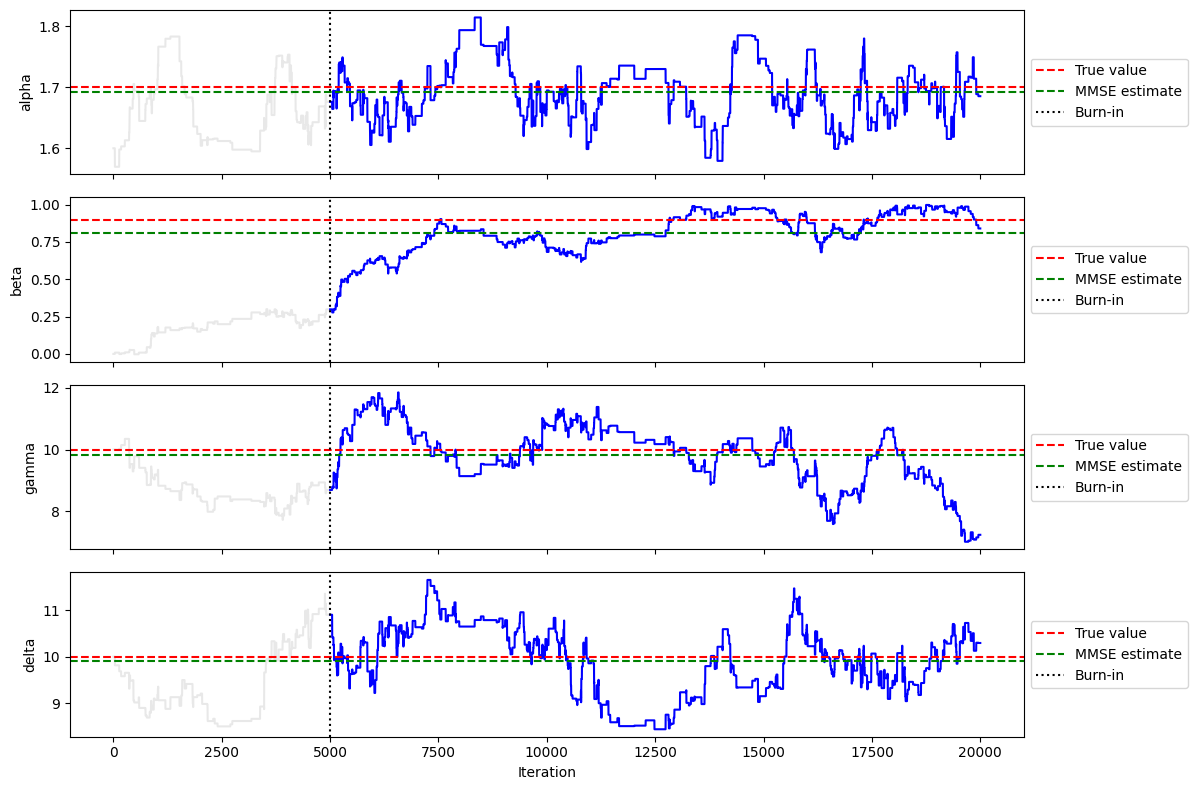


MMSE Estimates (post burn-in):
alpha: 1.6927 ± 0.0004
beta: 0.8127 ± 0.0011
gamma: 9.8277 ± 0.0079
delta: 9.9075 ± 0.0061


In [77]:
# Visualisation des traces 

np.random.seed(42)
y_star = sample_alpha_stable(alpha=1.7, beta=0.9, gamma=10, delta=10, size=1000)

# Lancer MCMC-ABC avec noyau gaussien et burn-in
start_params = [1.6, 0.0, 10.0, 10.0]
n_iter = 20000
burn_in = 5000  # Ajout du burn-in
epsilon = 0.2
proposal_scale = [0.02, 0.02, 0.2, 0.2]

chain, mmse_mcmc_estimates, std_errors_mcmc = abc_mcmc_gaussian_kernel(y_star, start_params, n_iter, epsilon, proposal_scale, burn_in=burn_in)

# Visualisation des traces avec burn-in
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)  # Augmenté la largeur pour accommoder la légende
labels = ['alpha', 'beta', 'gamma', 'delta']
true_values = [1.7, 0.9, 10, 10]

for i in range(4):
    param_name = labels[i]
    # Tracer la chaîne complète en gris clair
    axes[i].plot(range(burn_in), chain[:burn_in, i], color='lightgray', alpha=0.5)
    # Tracer la chaîne post burn-in en couleur
    axes[i].plot(range(burn_in, len(chain)), chain[burn_in:, i], color='blue')
    axes[i].axhline(true_values[i], color='red', linestyle='--', label='True value')
    axes[i].axhline(mmse_mcmc_estimates[param_name], color='green', linestyle='--', label='MMSE estimate')
    axes[i].axvline(x=burn_in, color='black', linestyle=':', label='Burn-in')
    axes[i].set_ylabel(param_name)
    # Déplacer la légende à droite
    axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[-1].set_xlabel('Iteration')
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Ajuster la marge droite pour la légende
plt.show()

# Afficher les résultats MMSE et erreurs standards
print("\nMMSE Estimates (post burn-in):")
for param in labels:
    print(f"{param}: {mmse_mcmc_estimates[param]:.4f} ± {std_errors_mcmc[param]:.4f}")

In [75]:
mmse_estimates

{'alpha': 1.6926756205010494,
 'beta': 0.812739290397532,
 'gamma': 9.827720976328573,
 'delta': 9.907455262427632}

## C- SMC-ABC Algorithm

In [64]:
# ——————————————————————————————————————————————
# Fonction permettant de retrouver M_t : Kernel de mutation 
# ——————————————————————————————————————————————

def mutation_kernel_density(theta_vec, particles_prev, weights_prev, Lambda):
    """
    Évalue la densité du kernel de mutation M_t en un point theta_vec.

    M_t(θ) = ∑_{i=1}^N W_{t-1}^{(i)} · φ(θ; θ_{t-1}^{(i)}, Λ)

    où :
      - particles_prev : liste de dictionnaires θ_{t-1}^{(i)} précédents
      - weights_prev   : array des poids normalisés W_{t-1}^{(i)}
      - Λ              : matrice de covariance (4×4) du kernel gaussien φ

    Paramètres
    ----------
    theta_vec : array-like, shape (4,)
        Le vecteur [α, β, γ, δ] où évaluer M_t.
    particles_prev : list of dict
        Particules de la population t–1.
    weights_prev : numpy.ndarray, shape (N,)
        Poids associés à particles_prev, tels que sum(weights_prev)=1.
    Lambda : numpy.ndarray, shape (4,4)
        Covariance du noyau de mutation φ.

    Retour
    ------
    dens : float
        Valeur de M_t(theta_vec).
    """
    dens = 0.0
    # Pour chaque particule i, on calcule la densité gaussienne φ centrée en θ_{t-1}^{(i)} avec covariance Λ
    # et on pondère cette densité par le poids w_i de la particule
    for w_i, th_i in zip(weights_prev, particles_prev):
        mean_i = np.array([th_i["alpha"], th_i["beta"], th_i["gamma"], th_i["delta"]])
        dens += w_i * multivariate_normal.pdf(theta_vec, mean=mean_i, cov=Lambda)
    return dens

In [50]:
# ——————————————————————————————————————————————
# 1. Phase d’initialisation SMC-ABC PRC
# ——————————————————————————————————————————————
def initialize_particles_with_gaussian_kernel(
    y_obs,         # données observées
    N,             # nombre de particules
    epsilon,       # tolérance initiale
    theta_hat,     # θ̂ pour estimer Σ̂ (ex : MLE ou valeurs vraies)
):
    """
    Retourne :
      - particles : liste de N dicts {"alpha", "beta", "gamma", "delta"}
      - weights   : array de N poids normalisés selon Kε
      - cov_matrix: matrice Σ̂ estimée pour le noyau
    """
    # 5.1 Calc. S₁(y_obs)
    s_obs = mcculloch_stats(y_obs, gamma=theta_hat["gamma"])
    # 5.2 Estimation unique de Σ̂
    cov_matrix = estimate_covariance_s1(theta_hat, P=1000)
    
    particles = []
    weights   = []
    
    for _ in range(N):
        # 5.3 Tirage du prior (uniforme sur les intervalles choisis)
        theta = {
            "alpha": np.random.uniform(0.1,  2.0),
            "beta":  np.random.uniform(-1.0, 1.0),
            "gamma": np.random.uniform(0.0,20),
            "delta": np.random.uniform(-20.0,20.0),
        }
        # 5.4 Simulation et résumé
        y_sim = sample_alpha_stable(**theta, size=len(y_obs))
        s_sim = mcculloch_stats(y_sim, gamma=theta["gamma"])
        # 5.5 Poids via noyau gaussien
        w = gaussian_kernel_s1(s_obs, s_sim, epsilon, cov_matrix)
        
        particles.append(theta)
        weights.append(w)
    
    # 5.6 Normalisation
    weights = np.array(weights)
    weights = weights / weights.sum() if weights.sum()>0 else np.ones(N)/N
    
    return particles, weights, cov_matrix

In [52]:
# ——————————————————————————————————————————————
# 1. Phase d’initialisation SMC-ABC PRC : Test 
# —————————————————————————————————————————————— 
np.random.seed(123)
# Simuler des données observées y_obs
y_obs = sample_alpha_stable(alpha=1.7, beta=0.9, gamma=10.0, delta=10.0, size=1000)
theta_hat = {"alpha": 1.7, "beta": 0.9, "gamma": 10.0, "delta": 10.0}
N = 10
epsilon = 0.2

particles, weights, cov_matrix = initialize_particles_with_gaussian_kernel(
    y_obs, N, epsilon, theta_hat
)

# Afficher les résultats succinctement
df_particles = pd.DataFrame(particles)
df_weights = pd.Series(weights, name="weight")
df_display = pd.concat([df_particles, df_weights], axis=1)

In [53]:
df_display

,alpha,beta,gamma,delta,weight
0,1.431400,-0.931241,17.313152,12.670497,7.611917e-08
1,1.891305,-0.540581,14.811679,10.524722,1.120727e-76
2,0.538755,0.803931,14.009388,-9.917573,0.000000e+00
3,0.850565,0.844326,19.837926,-18.624588,0.000000e+00
4,1.999749,-0.850090,4.463830,12.874407,3.499590e-190
5,0.246306,0.811276,16.166227,-16.259381,0.000000e+00
6,0.312825,0.922680,3.274345,-3.133279,0.000000e+00
7,1.683777,0.741306,18.508614,4.461109,9.708106e-01
8,1.866338,-0.090540,12.736421,-7.579958,0.000000e+00
9,1.845694,-0.369837,11.514553,12.873376,2.918929e-02


On remarque que l'effet de « dégénérescence » du kernel nécessite de resampler notre échantillon

In [54]:
import copy

def resample_particles(particles, weights):
    """
    Rééchantillonne N particules selon leurs poids et remet tous les poids à 1/N.
    
    Parameters:
    -----------
    particles : list of dict
        Liste des particules θ_t^{(i)} actuelles.
    weights : array-like, shape (N,)
        Poids normalisés associés à chaque particule.
    
    Returns:
    --------
    new_particles : list of dict
        Nouvelle liste de particules rééchantillonnées.
    new_weights : numpy.ndarray, shape (N,)
        Poids remis à 1/N pour chaque particule.
    """
    N = len(particles)
    # Tirage des indices selon la distribution des poids
    indices = np.random.choice(np.arange(N), size=N, p=weights)
    
    # On duplique (deep copy) les particules sélectionnées
    new_particles = [copy.deepcopy(particles[i]) for i in indices]
    
    # Poids uniformes 1/N après rééchantillonnage
    new_weights = np.ones(N) / N
    
    return new_particles, new_weights



In [55]:
# ——————————————————————————————————————————————
# 2. Phase de resampling SMC-ABC PRC : test
# ——————————————————————————————————————————————
particles_resample, weights_resample = resample_particles(particles, weights)
# Afficher les particules uniques
unique_particles = []
seen = set()
for p in particles_resample:
    # Convertir le dictionnaire en tuple pour pouvoir le hasher
    p_tuple = tuple(sorted(p.items()))
    if p_tuple not in seen:
        seen.add(p_tuple)
        unique_particles.append(p)
print(unique_particles)



[{'alpha': 1.6837773162231724, 'beta': 0.7413058436264126, 'gamma': 18.508613578815506, 'delta': 4.461109485853289}]


In [49]:
# ——————————————————————————————————————————————
# 3. Phase de mutation+correction SMC-ABC PRC
# ——————————————————————————————————————————————

def mutate_and_correct(
    particles_prev,
    weights_prev,
    cov_matrix,
    epsilon,
    y_obs,
    summary_stat_func,
    gamma_hat,
    Lambda=None
):
    """
    Exécute la phase de Mutation + Correction du SMC-ABC PRC (Peters et al. 2009).

    Étapes selon Peters et al. 2009:
    (a) Sample θ_t^(i) ~ M_t(θ_t) and set weight W_t(θ_t^(i)) = π_LF,t(θ_t^(i)|y)/M_t(θ_t^(i))
    (b) With probability 1-p^(i) = 1-min{1, W_t(θ_t^(i))/c_t}, reject θ_t^(i) and go to (a)
    (c) Otherwise, accept θ_t^(i) and set W_t(θ_t^(i)) = W_t(θ_t^(i))/p^(i)
    (d) Increment i=i+1. If i≤N, go to (a)

    Parameters
    ----------
    particles_prev : list of dict
        Particules de la population t–1.
    weights_prev : numpy.ndarray, shape (N,)
        Poids normalisés de la population t–1.
    cov_matrix : numpy.ndarray, shape (4,4)
        Σ̂ estimée des statistiques résumées S₁ pour le noyau gaussien d'observation.
    epsilon : float
        Tolérance ε_t pour le noyau d'observation K_ε.
    y_obs : array-like
        Données observées.
    summary_stat_func : function
        Fonction prenant (data, gamma) et retournant dict S₁ étendu.
    gamma_hat : float
        Valeur de gamma utilisée pour calculer S₁(y_obs).
    Lambda : numpy.ndarray, optional
        Matrice de covariance (4×4) du kernel de mutation.
        Si None, on utilise diag([0.25,0.25,1,1]).

    Returns
    -------
    new_particles : list of dict
        Liste des N particules de la nouvelle population.
    new_weights  : numpy.ndarray, shape (N,)
        Poids normalisés associés à new_particles.
    """
    N = len(particles_prev)
    
    # Seuil c_t = 90ᵉ percentile des poids précédents
    c_t = np.quantile(weights_prev, 0.9)

    # Kernel de mutation par défaut si non fourni
    if Lambda is None:
        Lambda = np.diag([0.25, 0.25, 1.0, 1.0])

    # Statistique observée calculée une seule fois
    s_obs = summary_stat_func(y_obs, gamma_hat)

    new_particles = []
    new_weights = []
    i = 0

    # (d) Boucle principale jusqu'à obtenir N particules
    while i < N:
        # (a) Sample θ_t^(i) ~ M_t(θ_t) and compute weight
        j = np.random.choice(N, p=weights_prev)
        th_j = particles_prev[j]
        base_vec = np.array([th_j["alpha"], th_j["beta"], th_j["gamma"], th_j["delta"]])
        
        # Sample from mutation kernel
        theta_prime = multivariate_normal.rvs(mean=base_vec, cov=Lambda)
        alpha_p, beta_p, gamma_p, delta_p = theta_prime

        # Skip if outside support
        if not (1e-2 < alpha_p <= 2 and -1 <= beta_p <= 1 and gamma_p > 1e-3):
            continue

        # Compute π_LF,t(θ_prime|y)
        y_sim = sample_alpha_stable(alpha_p, beta_p, gamma_p, delta_p, size=len(y_obs))
        s_sim = summary_stat_func(y_sim, gamma_p)
        pi_LF = gaussian_kernel_s1(s_obs, s_sim, epsilon, cov_matrix)

        # Compute M_t(θ_prime)
        M_t = mutation_kernel_density(theta_prime, particles_prev, weights_prev, Lambda)

        # Set weight W_t(θ_t^(i)) = π_LF,t(θ_t^(i)|y)/M_t(θ_t^(i))
        w_t = pi_LF / M_t

        # (b) Rejection step with probability 1-p^(i)
        p_keep = min(1.0, w_t / c_t)
        if np.random.rand() > p_keep:
            continue

        # (c) Accept particle and set corrected weight
        corrected_w = w_t / p_keep

        new_particles.append({
            "alpha": alpha_p,
            "beta":  beta_p,
            "gamma": gamma_p,
            "delta": delta_p
        })
        new_weights.append(corrected_w)
        i += 1

    # Normalisation finale pour obtenir ∑ W_t = 1
    new_weights = np.array(new_weights)
    new_weights /= new_weights.sum()

    return new_particles, new_weights

In [67]:
# ——————————————————————————————————————————————
# 3. Phase de mutation+correction SMC-ABC PRC : Test 
# ——————————————————————————————————————————————

# 1) Paramètres
gamma_hat = 10.0
epsilon_t = 0.2  # même tolérance qu’à l’initialisation, ou celle de l’étape t
Lambda = np.diag([0.25, 0.25, 1.0, 1.0])  # covariance du kernel de mutation

# 2) Appliquer la mutation + correction pour obtenir la population t = 1
particles_mutated, weights_mutated = mutate_and_correct(
    particles_prev    = particles_resample,
    weights_prev      = weights_resample,
    cov_matrix        = cov_matrix,
    epsilon           = epsilon_t,
    y_obs             = y_obs,
    summary_stat_func = mcculloch_stats,
    gamma_hat         = gamma_hat,
    Lambda            = Lambda
)

# 3) Construire un DataFrame pour visualiser la nouvelle population
df_particles_mut = pd.DataFrame(particles_mutated)
df_weights_mut   = pd.Series(weights_mutated, name="weight")
df_display_mut   = pd.concat([df_particles_mut, df_weights_mut], axis=1)

# 4) Afficher les 10 premières particules de la population t = 1 après mutation
print("=== Population t=1 après mutation + correction ===")
print(df_display_mut.head(10))

=== Population t=1 après mutation + correction ===
      alpha      beta      gamma     delta    weight
0  1.561733  0.915797  18.866935  5.653341  0.000046
1  1.608477  0.195571  20.503246  5.242469  0.000591
2  1.643035  0.577076  19.143401  5.822668  0.000775
3  1.676032  0.628665  18.379470  7.233455  0.934303
4  1.453365  0.309640  18.386263  4.264249  0.000298
5  1.527126  0.546024  19.935432  4.509511  0.000046
6  1.663382  0.265913  18.979684  6.618039  0.000093
7  1.584172  0.410064  17.267958  5.089485  0.000494
8  1.632233  0.707984  17.090270  7.271686  0.063074
9  1.499455  0.600603  19.866361  4.946856  0.000280


In [59]:
def make_epsilon_schedule():
    # Création de 50 valeurs espacées logarithmiquement entre 10 et 0.1
    eps = np.logspace(np.log10(10), np.log10(0.1), num=50)
    # Tri décroissant
    return np.sort(eps)[::-1]

epsilons = make_epsilon_schedule()

In [60]:
epsilons

array([10.        ,  9.10298178,  8.28642773,  7.54312006,  6.86648845,
        6.25055193,  5.68986603,  5.17947468,  4.71486636,  4.29193426,
        3.90693994,  3.55648031,  3.23745754,  2.9470517 ,  2.6826958 ,
        2.44205309,  2.22299648,  2.02358965,  1.84206997,  1.67683294,
        1.52641797,  1.38949549,  1.26485522,  1.1513954 ,  1.04811313,
        0.95409548,  0.86851137,  0.79060432,  0.71968567,  0.65512856,
        0.59636233,  0.54286754,  0.49417134,  0.44984327,  0.40949151,
        0.37275937,  0.33932218,  0.30888436,  0.28117687,  0.25595479,
        0.23299518,  0.21209509,  0.19306977,  0.17575106,  0.15998587,
        0.14563485,  0.13257114,  0.12067926,  0.10985411,  0.1       ])

In [61]:
# ——————————————————————————————————————————————
# Driver SMC-ABC PRC
# ——————————————————————————————————————————————
def smc_prc_driver(
    y_obs,
    N,
    epsilons,
    theta_hat,
    summary_stat_func=mcculloch_stats,
    Lambda=np.diag([0.25, 0.25, 1.0, 1.0])
):
    """
    SMC-ABC PRC avec planning d'epsilons fixe.
    """
    populations = []
    
    # 1) Initialisation t=1
    eps1 = epsilons[0]
    particles, weights, cov_matrix = initialize_particles_with_gaussian_kernel(
        y_obs=y_obs,
        N=N,
        epsilon=eps1,
        theta_hat=theta_hat
    )
    
    print(f"=== Initialisation t=1, ε₁={eps1:.4f} ===")
    populations.append((particles.copy(), weights.copy()))

    # 2) Resample initial
    particles, weights = resample_particles(particles, weights)
    print("  - Resampling effectué")

    # 3) Boucle t=2...T
    for t, eps in enumerate(epsilons[1:], start=2):
        print(f"\n=== Itération t={t}, εₜ={eps:.4f} ===")
        
        #Mutation + correction PRC
        particles, weights = mutate_and_correct(
            particles_prev    = particles,
            weights_prev      = weights,
            cov_matrix        = cov_matrix,
            epsilon           = eps,
            y_obs             = y_obs,
            summary_stat_func = summary_stat_func,
            gamma_hat         = theta_hat["gamma"],
            Lambda            = Lambda
        )
        print(f"  - Mutation PRC effectuée")
        
        #Resample systématique à chaque itération
        particles, weights = resample_particles(particles, weights)
        print("  - Resampling effectué")
        
        populations.append((particles.copy(), weights.copy()))

    return populations


In [66]:
# Configuration commune
N = 500
theta_hat = {"alpha":1.7, "beta":0.9, "gamma":10.0, "delta":10.0}

# Liste pour stocker les résultats des 10 simulations
all_pops = []

# Boucle sur les 10 simulations
for sim in range(10):
    print(f"\n=== Simulation {sim+1}/10 ===")
    
    # Générer de nouvelles données observées pour chaque simulation
    np.random.seed(123 + sim)  # Seed différent pour chaque simulation
    y_obs = sample_alpha_stable(1.7, 0.9, 10, 10, size=1000)
    
    # Exécuter SMC-ABC PRC
    pops = smc_prc_driver(
        y_obs=y_obs,
        N=N,
        epsilons=epsilons,
        theta_hat=theta_hat,
    )
    
    # Stocker les résultats
    all_pops.append(pops)


=== Simulation 1/10 ===
=== Initialisation t=1, ε₁=10.0000 ===
  - Resampling effectué

=== Itération t=2, εₜ=9.1030 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=3, εₜ=8.2864 ===


KeyboardInterrupt: 

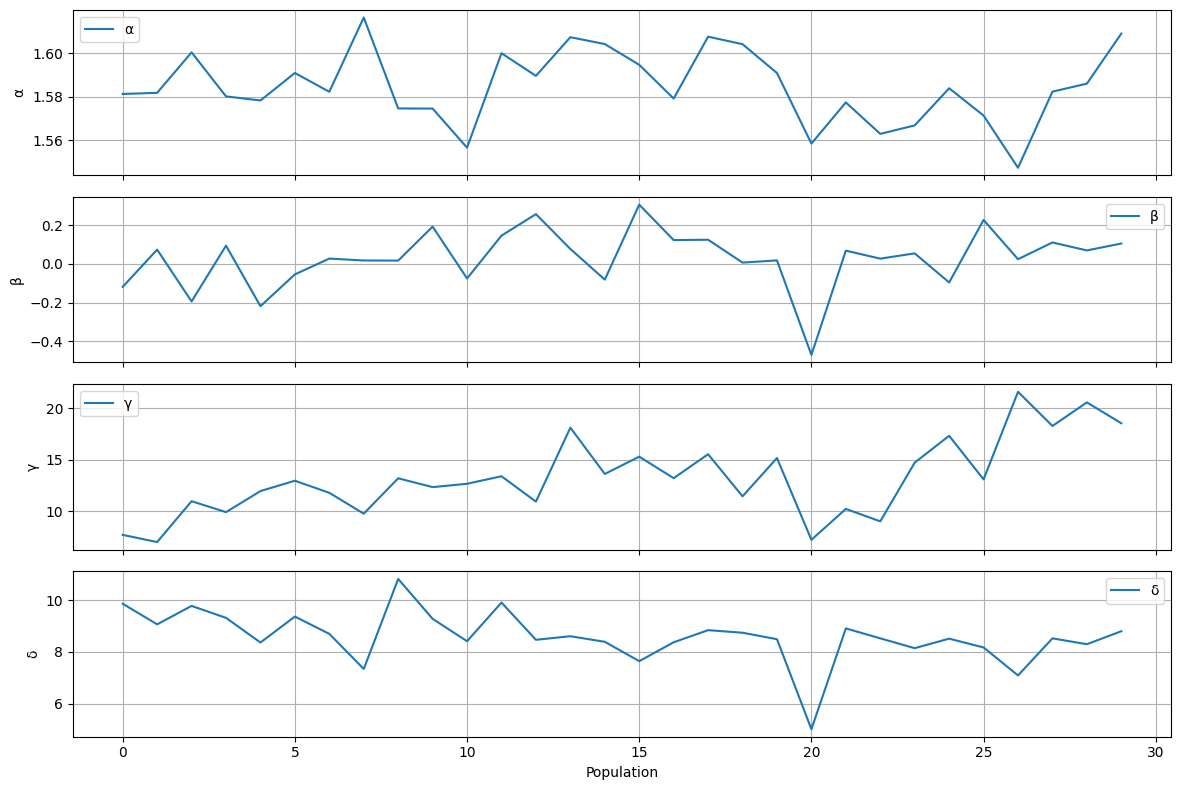

In [51]:
# Créer une figure avec 4 sous-graphiques pour les traces des paramètres
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Extraire les paramètres de chaque population
alphas = []
betas = []
gammas = []
deltas = []

for t, (particles, weights) in enumerate(pops):
    # Calculer la moyenne pondérée pour chaque paramètre
    alpha_mean = np.average([p['alpha'] for p in particles], weights=weights)
    beta_mean = np.average([p['beta'] for p in particles], weights=weights)
    gamma_mean = np.average([p['gamma'] for p in particles], weights=weights)
    delta_mean = np.average([p['delta'] for p in particles], weights=weights)
    
    alphas.append(alpha_mean)
    betas.append(beta_mean)
    gammas.append(gamma_mean)
    deltas.append(delta_mean)

# Tracer les traces
axes[0].plot(alphas, label='α')
axes[1].plot(betas, label='β')
axes[2].plot(gammas, label='γ')
axes[3].plot(deltas, label='δ')

# Ajouter les labels et titres
axes[0].set_ylabel('α')
axes[1].set_ylabel('β')
axes[2].set_ylabel('γ')
axes[3].set_ylabel('δ')
axes[3].set_xlabel('Population')

# Ajouter les légendes
for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Créer une figure avec 4 sous-graphiques pour les traces des paramètres
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Extraire les paramètres de chaque population pour chaque simulation
all_alphas = []
all_betas = []
all_gammas = []
all_deltas = []

# Stocker les MMSE pour chaque simulation
mmse_alphas = []
mmse_betas = []
mmse_gammas = []
mmse_deltas = []

for sim in all_pops:
    alphas = []
    betas = []
    gammas = []
    deltas = []
    
    for t, (particles, weights) in enumerate(sim):
        # Calculer la moyenne pondérée pour chaque paramètre
        alpha_mean = np.average([p['alpha'] for p in particles], weights=weights)
        beta_mean = np.average([p['beta'] for p in particles], weights=weights)
        gamma_mean = np.average([p['gamma'] for p in particles], weights=weights)
        delta_mean = np.average([p['delta'] for p in particles], weights=weights)
        
        alphas.append(alpha_mean)
        betas.append(beta_mean)
        gammas.append(gamma_mean)
        deltas.append(delta_mean)
    
    # Calculer MMSE pour cette simulation
    mmse_alphas.append(np.mean(alphas))
    mmse_betas.append(np.mean(betas))
    mmse_gammas.append(np.mean(gammas))
    mmse_deltas.append(np.mean(deltas))
    
    all_alphas.append(alphas)
    all_betas.append(betas)
    all_gammas.append(gammas)
    all_deltas.append(deltas)

# Tracer les traces pour chaque simulation
for i in range(len(all_pops)):
    axes[0].plot(all_alphas[i], color='gray', alpha=0.3)
    axes[1].plot(all_betas[i], color='gray', alpha=0.3)
    axes[2].plot(all_gammas[i], color='gray', alpha=0.3)
    axes[3].plot(all_deltas[i], color='gray', alpha=0.3)

# Calculer et tracer les moyennes
mean_alphas = np.mean(all_alphas, axis=0)
mean_betas = np.mean(all_betas, axis=0)
mean_gammas = np.mean(all_gammas, axis=0)
mean_deltas = np.mean(all_deltas, axis=0)

axes[0].plot(mean_alphas, color='lightgray', linewidth=2, label='Moyenne')
axes[1].plot(mean_betas, color='lightgray', linewidth=2, label='Moyenne')
axes[2].plot(mean_gammas, color='lightgray', linewidth=2, label='Moyenne')
axes[3].plot(mean_deltas, color='lightgray', linewidth=2, label='Moyenne')

# Ajouter les labels et titres
axes[0].set_ylabel('α')
axes[1].set_ylabel('β')
axes[2].set_ylabel('γ')
axes[3].set_ylabel('δ')
axes[3].set_xlabel('Population')

# Ajouter les légendes
for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Calculer et afficher les MMSE et erreurs-types
final_mmse_alpha = np.mean(mmse_alphas)
final_mmse_beta = np.mean(mmse_betas)
final_mmse_gamma = np.mean(mmse_gammas)
final_mmse_delta = np.mean(mmse_deltas)

mcse_alpha = np.std(mmse_alphas) / np.sqrt(10)
mcse_beta = np.std(mmse_betas) / np.sqrt(10)
mcse_gamma = np.std(mmse_gammas) / np.sqrt(10)
mcse_delta = np.std(mmse_deltas) / np.sqrt(10)

print("\nMMSE et erreurs-types Monte Carlo:")
print(f"α: {final_mmse_alpha:.3f} ({mcse_alpha:.3f})")
print(f"β: {final_mmse_beta:.3f} ({mcse_beta:.3f})")
print(f"γ: {final_mmse_gamma:.3f} ({mcse_gamma:.3f})")
print(f"δ: {final_mmse_delta:.3f} ({mcse_delta:.3f})")



L'algorithme implémenté est bien un SMC (Sequential Monte Carlo) sampler avec une approche PRC-ABC (Population-based Rejection Control Approximate Bayesian Computation). Voici les caractéristiques qui le confirment :

1. Structure SMC :
- Utilisation de populations successives (pops)
- Pondération des particules (weights)
- Adaptation progressive des seuils d'acceptation (epsilon)

2. Composante PRC-ABC :
- Rejet basé sur une distance entre statistiques observées et simulées
- Utilisation d'un noyau gaussien pour l'acceptation
- Contrôle de la population via les poids des particules

3. Caractéristiques spécifiques :
- Adaptation des seuils d'acceptation
- Rééchantillonnage des particules
- Propagation des particules via des noyaux de proposition
- Calcul de statistiques résumées (McCulloch)

L'algorithme combine donc les avantages du SMC (exploration efficace de l'espace des paramètres) avec ceux de l'ABC (inférence sans vraisemblance explicite), tout en utilisant le contrôle de population pour maintenir la diversité des particules.


In [52]:
# Calcul des moyennes et écarts-types des paramètres
alpha_mean = np.mean(alphas)
alpha_std = np.std(alphas)
beta_mean = np.mean(betas)
beta_std = np.std(betas)
gamma_mean = np.mean(gammas)
gamma_std = np.std(gammas)
delta_mean = np.mean(deltas)
delta_std = np.std(deltas)

# Affichage des résultats
print(f"α: {alpha_mean:.3f} ({alpha_std:.3f})")
print(f"β: {beta_mean:.3f} ({beta_std:.3f})")
print(f"γ: {gamma_mean:.3f} ({gamma_std:.3f})")
print(f"δ: {delta_mean:.3f} ({delta_std:.3f})")


α: 1.585 (0.017)
β: 0.029 (0.151)
γ: 13.247 (3.680)
δ: 8.592 (1.002)


In [83]:
# Création du tableau récapitulatif avec les paramètres en lignes et les méthodes en colonnes
results = pd.DataFrame({
    'Paramètre': ['α(1.7)', 'β(0.9)', 'γ(10)', 'δ(10)'],
    'ABC Reject': [f"{alpha_reject_mean:.3f}({alpha_reject_std:.3f})", 
                  f"{beta_reject_mean:.3f}({beta_reject_std:.3f})",
                  f"{gamma_reject_mean:.3f}({gamma_reject_std:.3f})",
                  f"{delta_reject_mean:.3f}({delta_reject_std:.3f})"],
    'ABC MCMC': [f"{mmse_mcmc_estimates['alpha']:.3f}({std_errors_mcmc['alpha']:.3f})",
                f"{mmse_mcmc_estimates['beta']:.3f}({std_errors_mcmc['beta']:.3f})",
                f"{mmse_mcmc_estimates['gamma']:.3f}({std_errors_mcmc['gamma']:.3f})",
                f"{mmse_mcmc_estimates['delta']:.3f}({std_errors_mcmc['delta']:.3f})"],
    'ABC SMC': [f"{alpha_mean:.3f}({alpha_std:.3f})",
                f"{beta_mean:.3f}({beta_std:.3f})",
                f"{gamma_mean:.3f}({gamma_std:.3f})",
                f"{delta_mean:.3f}({delta_std:.3f})"]
})

# Affichage du tableau avec une mise en forme améliorée
print("\nTableau récapitulatif des résultats ABC :")
print(results.to_string(index=False))


NameError: name 'alpha_mean' is not defined

## Question 4 — ABC for Multivariate Alpha-Stable Distributions

This section extends the ABC framework to **multivariate alpha-stable distributions**, as outlined in the bonus question of the project.

Since the multivariate stable density is intractable, Approximate Bayesian Computation (ABC) is particularly suitable. We assume that we can simulate from the model, but cannot evaluate the likelihood $( p(y|\theta) $), especially in multivariate contexts.

We implement the following components:

- A multivariate generator based on a generalization of the Chambers-Mallows-Stuck (CMS) algorithm.
- A custom summary statistic tailored for multivariate data.
- A rejection-based ABC algorithm accepting parameters if the simulated summaries are close enough to those of the observed data.



### Multivariate CMS Generator

We consider symmetric multivariate alpha-stable distributions of the form:

$$
X = R \cdot A Z
$$

Where:
- $R$ is a positive scalar drawn from the univariate CMS stable generator.
- $Z$ is a random direction on the unit sphere.
- $A$ is the square-root matrix (e.g., Cholesky) of the dispersion matrix $\Sigma$.

This method produces samples from the multivariate alpha-stable distribution with stability parameter $\alpha \in (0, 2]$.

In [3]:
def sample_multivariate_alpha_stable(alpha, cov_matrix, size=1):
    """
    Génère des échantillons d'une loi alpha-stable symétrique multivariée.
    Basé sur le générateur CMS généralisé.

    Paramètres
    ----------
    alpha : float
        Stabilité de la loi (0 < alpha <= 2).
    cov_matrix : np.ndarray
        Matrice de dispersion (positive semi-définie), p x p.
    size : int
        Nombre d’échantillons à générer.

    Retour
    ------
    samples : np.ndarray
        Tableau de shape (size, p).
    """
    p = cov_matrix.shape[0]
    Z = np.random.normal(size=(size, p))  # vecteur isotrope
    Z = Z / np.linalg.norm(Z, axis=1, keepdims=True)

    # Générateur CMS scalaire
    U = np.random.uniform(-np.pi/2, np.pi/2, size)
    W = np.random.exponential(1, size)

    scalar_samples = np.sin(alpha * U) / (np.cos(U) ** (1/alpha)) * \
                     (np.cos((1 - alpha) * U) / W) ** ((1 - alpha) / alpha)

    # Produit par la racine de la matrice de dispersion
    L = np.linalg.cholesky(cov_matrix)
    return scalar_samples[:, None] * (Z @ L.T)


### Summary Statistics for Multivariate Data

We define the following summary statistics to compare simulated and observed samples:

- The **empirical mean vector** $\bar{X} = \frac{1}{n} \sum_{i=1}^n X_i$
- The **empirical covariance matrix** $\hat{\Sigma} = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})(X_i - \bar{X})^\top$
- Optionally, **marginal McCulloch statistics** applied to each coordinate

These summaries are used to compute the distance between observed and simulated samples.


In [5]:
def multivariate_summary_stats(data):
    """
    Calcule des statistiques de résumé multivariées.
    data: shape (n_samples, dim)
    """
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    cov = np.cov(data.T)
    return {
        "mean": means,
        "std": stds,
        "cov": cov
    }


### ABC-Rejection for Multivariate Stable Distributions

We implement a rejection-based ABC algorithm:

1. Draw parameters $\theta = (\alpha, \Sigma)$ from the prior.
2. Generate $n$ samples from the multivariate stable law using the CMS generator.
3. Compute summary statistics $S(Y)$ for simulated data and $S(Y^\star)$ for observed data.
4. Compute the Euclidean distance: $d(S(Y), S(Y^\star))$.
5. Accept $\theta$ if $d(S(Y), S(Y^\star)) < \varepsilon$.

This yields a set of accepted parameters approximating the posterior distribution $\pi(\theta \mid Y^\star)$.


In [22]:
def abc_reject_multivariate(y_star, alpha_range, cov_matrices, n_samples, epsilon):
    accepted = []
    y_star_stats = multivariate_summary_stats(y_star)

    while len(accepted) < n_samples:
        alpha = np.random.uniform(*alpha_range)
        cov = cov_matrices[np.random.randint(0, len(cov_matrices))]

        y_sim = sample_multivariate_alpha_stable(alpha, cov, size=len(y_star))
        y_sim_stats = multivariate_summary_stats(y_sim)

        # distance sur les moyennes uniquement, pour simplifier
        dist = np.linalg.norm(y_sim_stats["mean"] - y_star_stats["mean"])
        
        if dist < epsilon:
            accepted.append({"alpha": alpha, "cov": cov, "distance": dist})

    return accepted
